In [1]:
import weight_perturbation as wp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import torch

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
def convex_forward(inputs, params):
    """
    A simple loss landscape to optimize
    """
    if type(params) == dict:
        weights = params["vars"]
    else:
        weights = params
    return torch.sum(weights**2)

In [4]:
n_steps = 1000
method = "ffd"
sigma = 1e-6
lr = 1e-2
sampler = torch.distributions.Normal(0, sigma)
# make a sampler

Ndim = 2

start_sampler = torch.distributions.Normal(0, 10)
initial_params = start_sampler.sample(sample_shape=torch.Size([Ndim]))
params = {"vars" : initial_params}

history = np.empty((n_steps, Ndim))

for e in range(n_steps):
    wp_grad = wp.compute_gradient(
        convex_forward, None, params, sampler, method
    )  # do forward passes and compute gradient
    params = wp.update_weights(wp_grad, params, sigma, lr)
    history[e, :] = params["vars"]

C:\Users\tomha\anaconda3\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<Figure size 640x480 with 0 Axes>

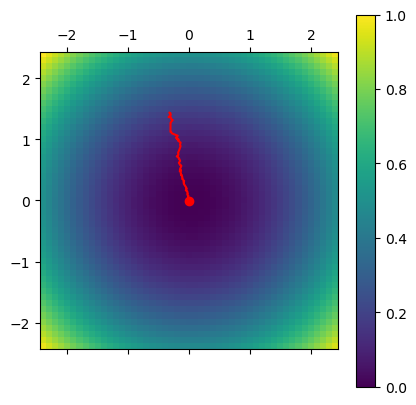

In [5]:
def plot_trajectory(history, loss_fun, grid_size):
    space = np.max(np.abs(history[0])) + 1
    xyspace = torch.arange(-space, space, grid_size)
    X, Y = torch.meshgrid(xyspace, xyspace)
    coords = torch.stack([X, Y], dim=2)
    loss_space = torch.tensor([[loss_fun(None, x).squeeze() for x in row] for row in coords])
    plt.figure()
    plt.matshow(loss_space, extent=[-space, space, -space, space])
    plt.plot(history[:, 0], history[:, 1], color='r')
    plt.scatter(history[-1, 0], history[-1, 1], color='r')
    plt.colorbar(norm=clrs.LogNorm(0, torch.max(loss_space)))
    plt.show()
plot_trajectory(history, convex_forward, 0.1)

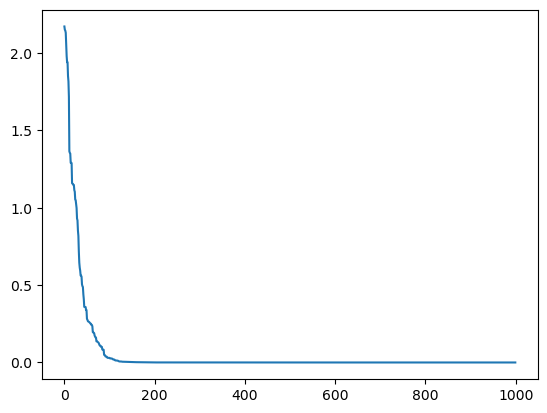

In [6]:
plt.figure()
loss_history = [convex_forward(None, {"vars" : torch.from_numpy(params)}) for params in history]
plt.plot(loss_history)
plt.show()